In [89]:
from sklearn.cluster import KMeans

import TimeDelay_Neuron_DDF_GaussianForm as TDG
import TimeDelay_Neuron_DDF_GaussianForm_Leak as TDGL
import TimeDelay_Neuron_DDF_GaussianForm_Leak_ITD as TDGLI

import Fourier_Power_Spectrum
import plotting_utilities
import save_utilities
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import copy
import glob
import os

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits import mplot3d

import numpy.fft
import math

import os

random.seed(2022)
np.random.seed(2022)

# This code is an edit branching off of Python code
# "User Side Code Separate Train and Test Same Epoch Different CM Auto File Loop"
# on June 6, 2022. I'm using new function definitions to make this file a cleaned up version of that file.

dir_fish = "fish_data/"

# In[2]:
# modify this
save_and_or_display = "save"

# epoch = None # also called "episode". set to None if not specified
tau_arr = np.array([10])#np.array(range(10, 20)) # math notation: range(2,10) = all integers in bounds [2,9)
D_arr = np.array([10])#np.array(range(2, 10)) # math notation: range(2,10) = all integers in bounds [2,9)
beta_arr = np.array(np.power(10.0,[1]))#np.array(np.power(10.0,range(-3,3))) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
R_arr = np.array(np.power(10.0,[-8])) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
file_extension = "txt" # string; examples: "atf" or "txt" (case sensitive); don't include period; lowercase

# specify what the neuron names are in the file titles here:
neuron_name_list = [""] # example: ['32425a75', '920061fe'] are two CM neurons from Meliza's 2014 data
Current_units = "pA"
Voltage_units = "mV"
Time_units = "ms"
TT = 0.02 # delta t in Time_units units, time between samples if not specified through loaded files

# Data directory to recursively load data from:
root_directory = "Data2022-50KhZ/" # example: "HVC_biocm_data/simulations/" ; Include the final "/"

# Use only this file:
files_to_evaluate = []#"biocm_phasic_lzo_1_1_10_100_200.mat"] # leave this list empty if you want to evaluate all files in root_directory recursively

do_not_use_list = [] # bad data for RBF training

FPS_xlim= (0,0.175)

fraction_of_data_for_training = 4.0/6.0

# In[3]:

# ======== do not modify below ==========
print("Extensions searched: "+str(save_utilities.glob_extension_case_string_builder(file_extension)))
full_paths_list = glob.glob(root_directory+"**/*."+str(save_utilities.glob_extension_case_string_builder(file_extension)),
                            recursive=True)
neuron_name = "" # leave as "" if no neuron name is found
# Files to ignore within directory:

extensions_with_included_unit_data = ["abf","mat"]

# Code for 2014 Meliza CM data
for i, path in enumerate(full_paths_list):
    full_paths_list[i] = path.replace("\\","/")

print("Full paths list:"+str(full_paths_list))

# In[4]:

for a_path in full_paths_list:
    if file_extension.lower() == "txt":
        if "voltage" in a_path.lower(): # skip files if 'voltage' in filename. Only need to perform rest of this loop when 'current' in filename, to avoid duplicating work.
            continue
    # if "epoch_5" not in a_path:
    #     continue
    # if "Neuron 2" not in a_path:
    #     continue
    last_slash_location = a_path.rfind("/")
    a_filename = a_path[last_slash_location+1:]
    if len(files_to_evaluate)>0 and a_filename not in files_to_evaluate:
        continue
    directory_to_read_input_data = a_path[:last_slash_location+1] # should include the last slash, but nothing past it
    directory_to_store_plots = "plots/" + directory_to_read_input_data + str(a_filename[:-4]) + "/"
    directory_to_store_txt_data = "data_derived/" + directory_to_read_input_data + 'txt_V_I_t/'
    neuron_name = save_utilities.give_name_if_included_in_path(a_path, neuron_name_list)

Extensions searched: [tT][xX][tT]
Full paths list:['Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 1/epoch_1.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 1/epoch_2.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 1/epoch_3.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 1/epoch_4.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 1/epoch_5.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 1/epoch_6.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 1/epoch_7.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 2/epoch_1.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 2/epoch_2.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 2/epoch_3.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 3/epoch_1.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 3/epoch_2.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 3/epoch_3.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 3/epoch_4.txt', 'Data2022-50KhZ/11-30-2022/Lilac 157/Neuron 3/epoch_5.txt', 'Data2022-50KhZ/11-30-2022/Lilac 160/Neuron 1/epo

In [90]:
D=10
beta = np.power(10.0,0)#np.array(np.power(10.0,range(-3,3))) #range(-3,3) makes array go from 1e-3 to 1e2, not 1e3
R = np.power(10.0,-8)
tau=10

filename = "Lilac 242 Neuron 1 Epoch 9"
neuron_and_epoch_dir = "fish_L242n1e9/"
title_here = str(', D = '+str(D)+', Beta = '+str("{:.1e}".format(beta))+', R = '+str("{:.1e}".format(R))+', tau = '+str(tau))

In [91]:
if file_extension.lower() in extensions_with_included_unit_data: # primarily .abf and .mat files
    print("File may have included units which will override units specified by user at top of this code.")
    units_list = save_utilities.load_and_prepare_abf_or_mat_data(directory_to_read_input_data, a_filename,
                                                    directory_to_store_txt_data, file_extension)
    Current_units, Voltage_units, Time_units = units_list
    imported_data = np.loadtxt(directory_to_store_txt_data + str(a_filename[:-4]) + "_VIt.txt")

    loaded_V = imported_data[:, 0]
    loaded_I = imported_data[:, 1]
    loaded_t = imported_data[:, 2]
else: # primarily .txt files
    if root_directory=="Data2022-50KhZ/":
        loaded_IV = np.loadtxt(a_path)
        loaded_I = loaded_IV[:, 0]
        loaded_V = loaded_IV[:, 1]
    else:
        if 'current' in a_path:
            voltage_filepath = a_path.replace('current','voltage')
        if 'Current' in a_path:
            voltage_filepath = a_path.replace('Current','Voltage')
        loaded_V = np.loadtxt(voltage_filepath)
        loaded_I = np.loadtxt(a_path)
    loaded_t = TT*np.array(range(len(loaded_V)))

total_num_timesteps_in_data = len(loaded_V)
train_timestep_end = round(total_num_timesteps_in_data*fraction_of_data_for_training) #4/6 for neuron 2 epoch 5, and 5/6 for everything else

used_Voltage_train = loaded_V[:train_timestep_end - 1000 + tau*D]
Voltage_test = loaded_V[train_timestep_end:total_num_timesteps_in_data]
Voltage_train = loaded_V[:train_timestep_end]
Current_train = loaded_I[:train_timestep_end]
PreLength = Voltage_test.shape[0]-1000 # - 1000 just to give breathing room
Time_test    = loaded_t[train_timestep_end:total_num_timesteps_in_data]
bias = tau*(D-1)+1
X = Time_test[bias:bias+PreLength]
length = Voltage_train.shape[0]-1000 # - 1000 just to give breathing room


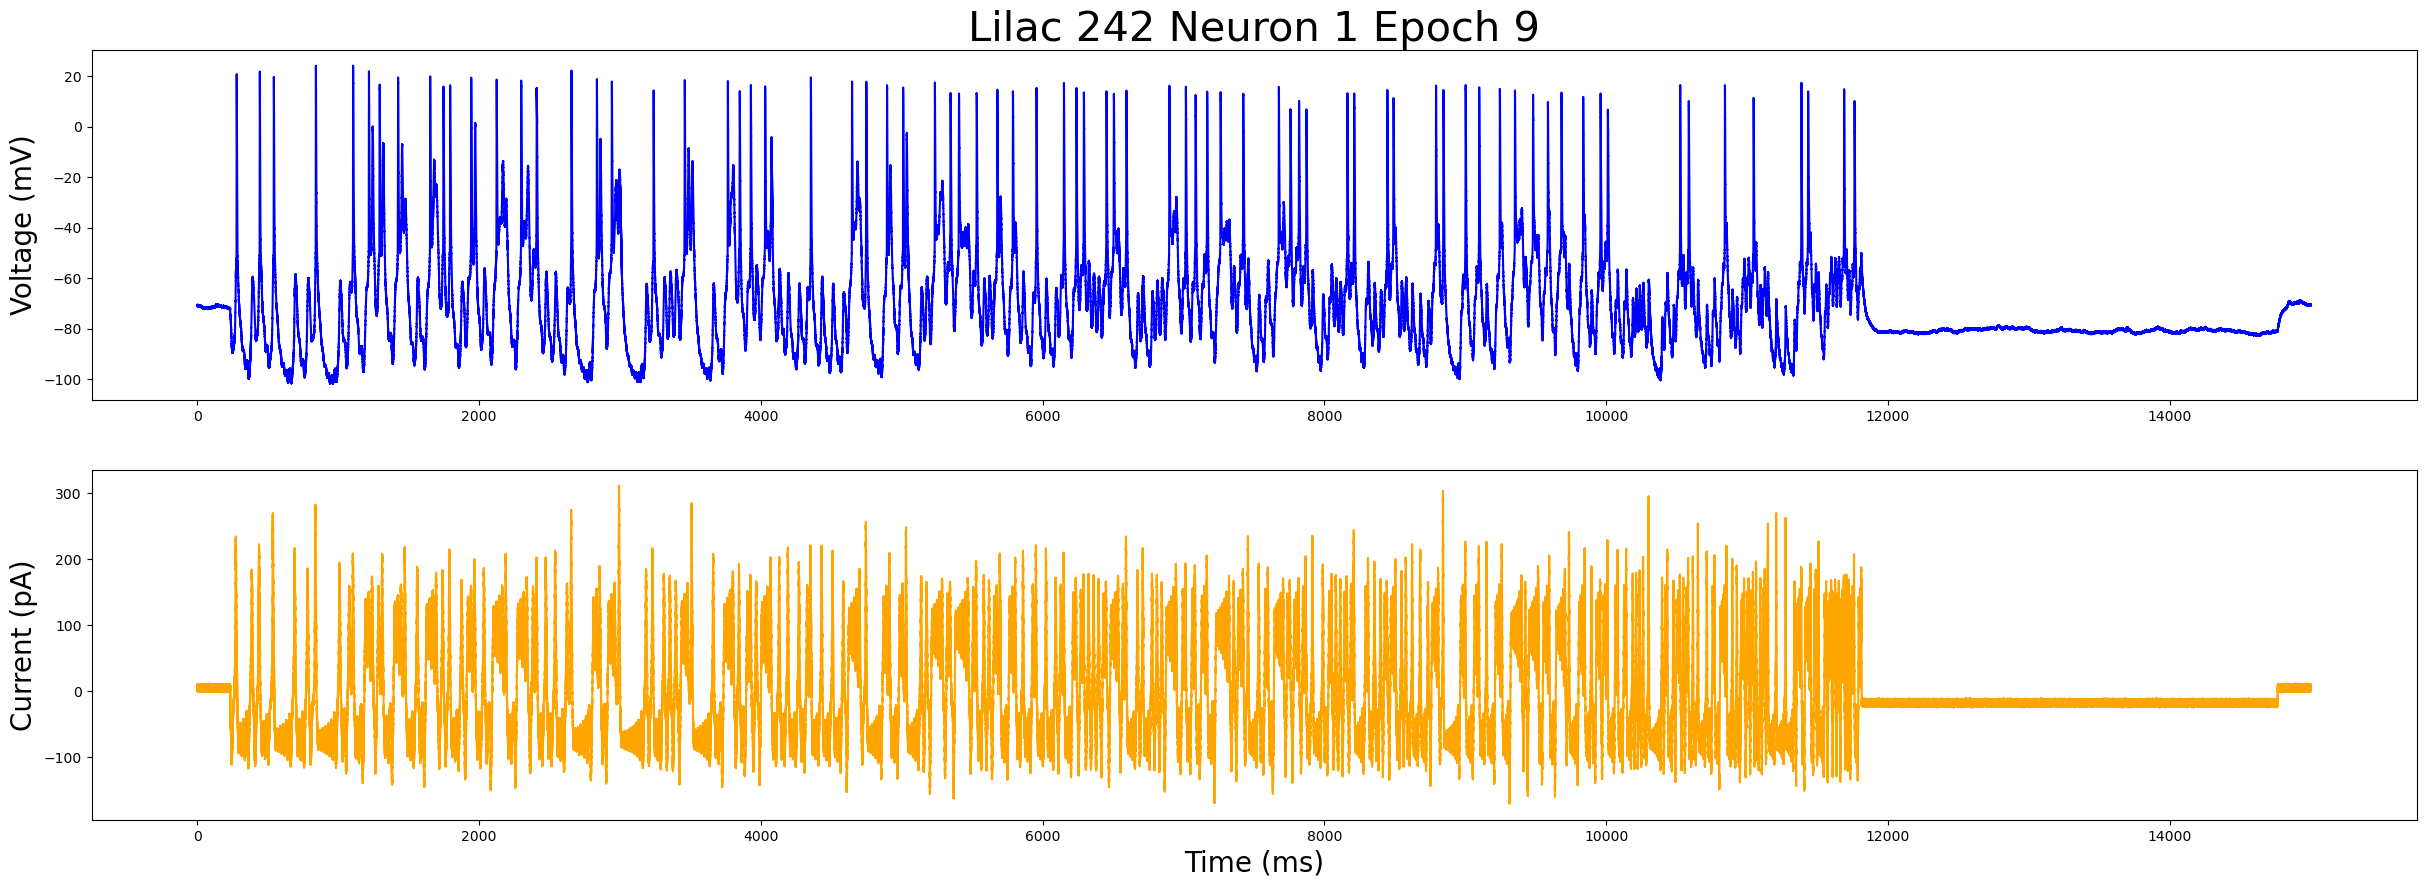

In [92]:
plt.figure(figsize=(30,10))

plt.subplot(2, 1, 1)
plt.plot(loaded_t,loaded_V, color = 'blue')
plt.ylabel('Voltage (mV)',fontsize=20)
plt.title(filename,fontsize=30)

plt.subplot(2, 1, 2)
plt.plot(loaded_t,loaded_I, color = 'orange')
plt.ylabel('Current (pA)',fontsize=20)
plt.xlabel('Time (ms)',fontsize=20)

def create_directory(path):
    # Check if the directory exists
    if not os.path.exists(path):
        # If it doesn't exist, create it
        os.makedirs(path)

# Test it with a directory path
create_directory(dir_fish+neuron_and_epoch_dir)

plt.savefig(dir_fish+neuron_and_epoch_dir+filename)

In [93]:
Xdata_Leak_ITD = np.vstack((Voltage_train, Current_train))

In [94]:
Xdata = Voltage_train
Xdata_Leak_ITD = np.vstack((Voltage_train, Current_train))
NoCenters_no_thresh = 500
# NoCenters_above_thresh = 50
DDF = TDG.Gauss()
DDF_Leak = TDGL.Gauss()
DDF_Leak_ITD = TDGLI.Gauss()

import os
import pickle

centers_file = "centers.pkl"
center_leak_itd_file = "center_leak_itd.pkl"
F_file = "F.pkl"
F_Leak_file = "F_Leak.pkl"
F_Leak_ITD_file = "F_Leak_ITD.pkl"

# Check if the files exist, and load or save the variables accordingly
if os.path.exists(dir_fish+centers_file):
    with open(dir_fish+centers_file, "rb") as f:
        Center = pickle.load(f)
else:
    # Save the Centers variable to the file
    with open(dir_fish+centers_file, "wb") as f:
        Center = DDF.KmeanCenter(Xdata,NoCenters_no_thresh,D,length,tau)
        pickle.dump(Center, f)

if os.path.exists(dir_fish+center_leak_itd_file):
    with open(dir_fish+center_leak_itd_file, "rb") as f:
        Center_Leak_ITD = pickle.load(f)
else:
    # Save the Center_Leak_ITD variable to the file
    with open(dir_fish+center_leak_itd_file, "wb") as f:
        Center_Leak_ITD = DDF_Leak_ITD.KmeanCenter(Xdata_Leak_ITD,NoCenters_no_thresh,D,length,tau)
        pickle.dump(Center_Leak_ITD, f)


stim_train = Current_train

F = DDF.FuncApproxF(Xdata,length,Center,beta,R,D,stim_train,tau)
F_Leak = DDF_Leak.FuncApproxF(Xdata,length,Center,beta,R,D,stim_train,tau)
F_Leak_ITD = DDF_Leak_ITD.FuncApproxF(Xdata_Leak_ITD,length,Center_Leak_ITD,beta,R,D,stim_train,tau)

Pdata = Voltage_test
Current_test = loaded_I[train_timestep_end:total_num_timesteps_in_data]

PredValidation = DDF.PredictIntoTheFuture(F,PreLength,Current_test[bias-1:],Pdata[bias-1-(D-1)*tau:])
PredValidation_Leak = DDF_Leak.PredictIntoTheFuture(F_Leak,PreLength,Current_test[bias-1:],Pdata[bias-1-(D-1)*tau:])
PredValidation_Leak_ITD = DDF_Leak_ITD.PredictIntoTheFuture(F_Leak_ITD,PreLength,Current_test[bias-1:],Pdata[bias-1-(D-1)*tau:],Current_test[bias-1-(D-1)*tau:])


Length+1: 499001
Shape of Xdata: (500000,)
Shape of XTau: (10, 499001)
Sample Xdata over length:(90, 499091)
Length+1: 499001
Shape of Xdata: (500000,)
Shape of XTau: (10, 499001)
Sample Xdata over length:(90, 499091)
Length+1: 499001
Shape of Xdata: (2, 500000)
Shape of XTau: (20, 499001)
Sample Xdata over length:(90, 499091)


In [95]:
lines = []
for i in range(len(X)):
    s = str(X[i])+"\t"+str(Pdata[bias:bias + PreLength][i])+"\t"+str(PredValidation[tau*(D-1)+1:tau*(D-1)+PreLength+1][i])
    lines.append(s)
with open('figure_17_data.txt', 'w') as f:
    f.write('\n'.join(lines))

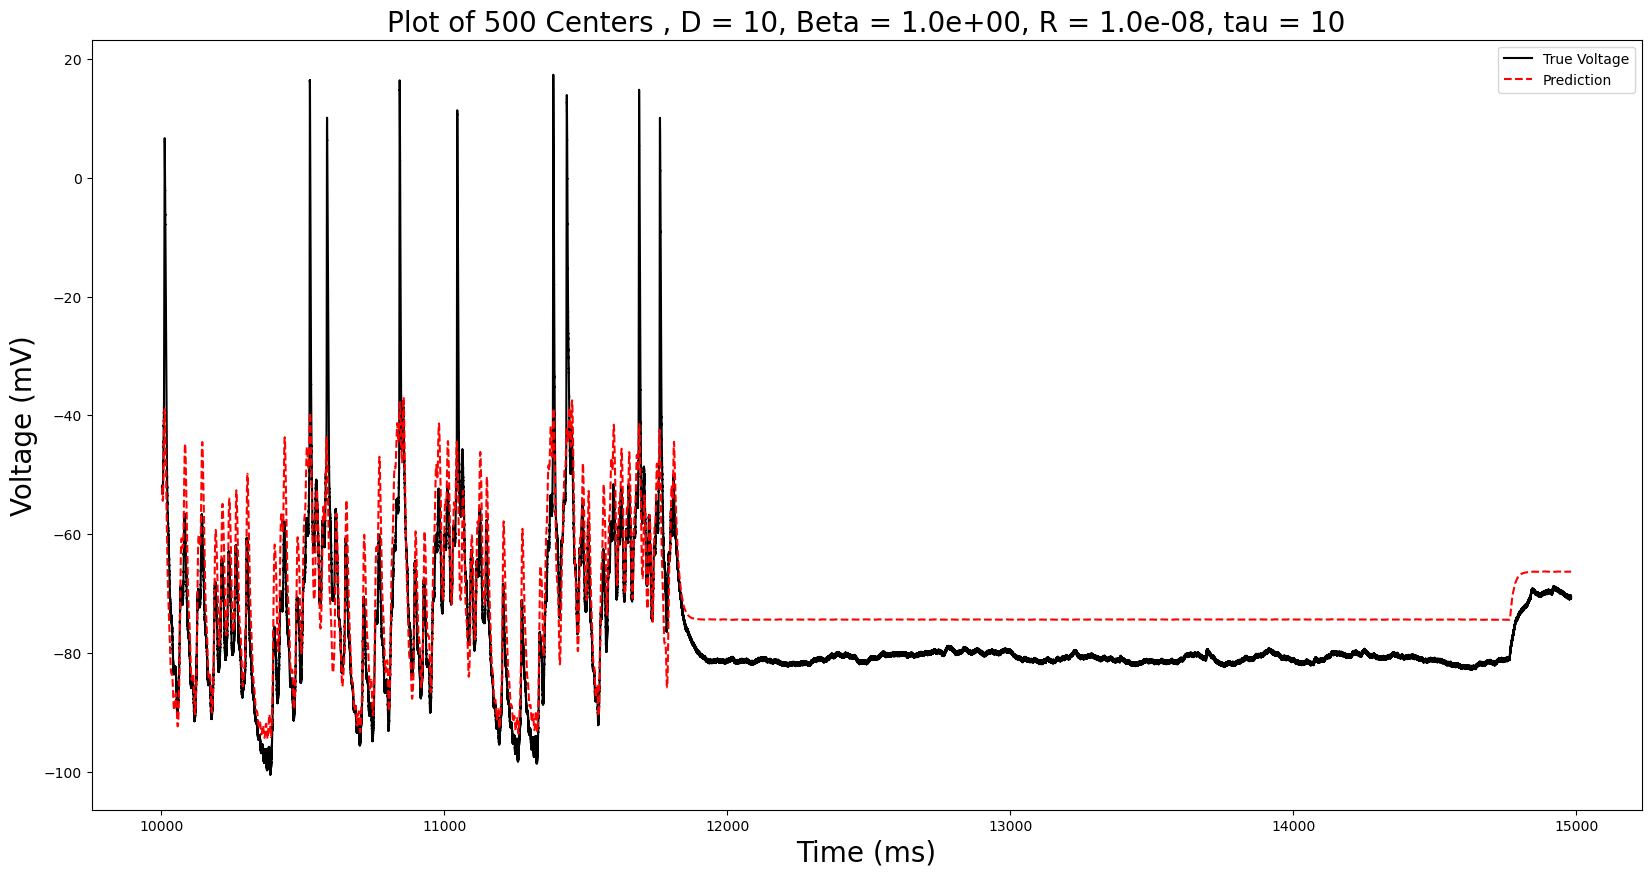

In [96]:
plt.figure(figsize=(20,10))
plt.plot(X,Pdata[bias:bias + PreLength],label = 'True Voltage', color = 'black')
plt.plot(X,PredValidation[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = 'Prediction')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title(f'Plot of {NoCenters_no_thresh} Centers '+title_here,fontsize=20)
plt.savefig(dir_fish+f'{NoCenters_no_thresh} Centers '+title_here+'.png')

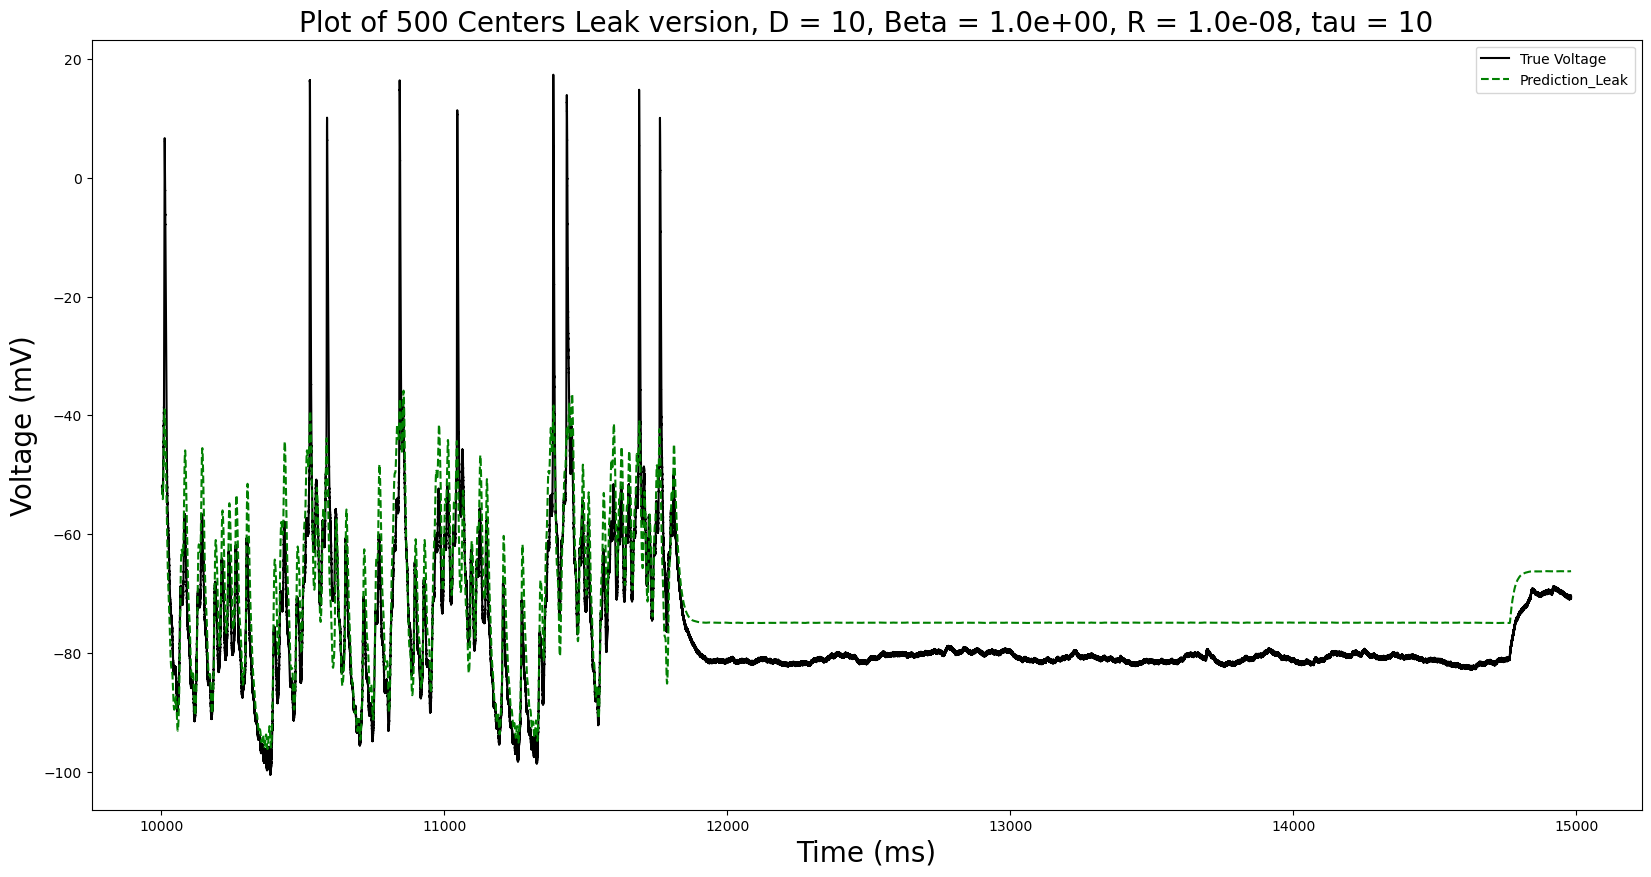

In [97]:
plt.figure(figsize=(20,10))
plt.plot(X,Pdata[bias:bias + PreLength],label = 'True Voltage', color = 'black')
plt.plot(X,PredValidation_Leak[tau*(D-1)+1:tau*(D-1)+PreLength+1],'g--',label = 'Prediction_Leak')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title(f'Plot of {NoCenters_no_thresh} Centers Leak version'+title_here,fontsize=20)
plt.savefig(dir_fish+f'{NoCenters_no_thresh} Centers Leak version'+title_here+'.png')

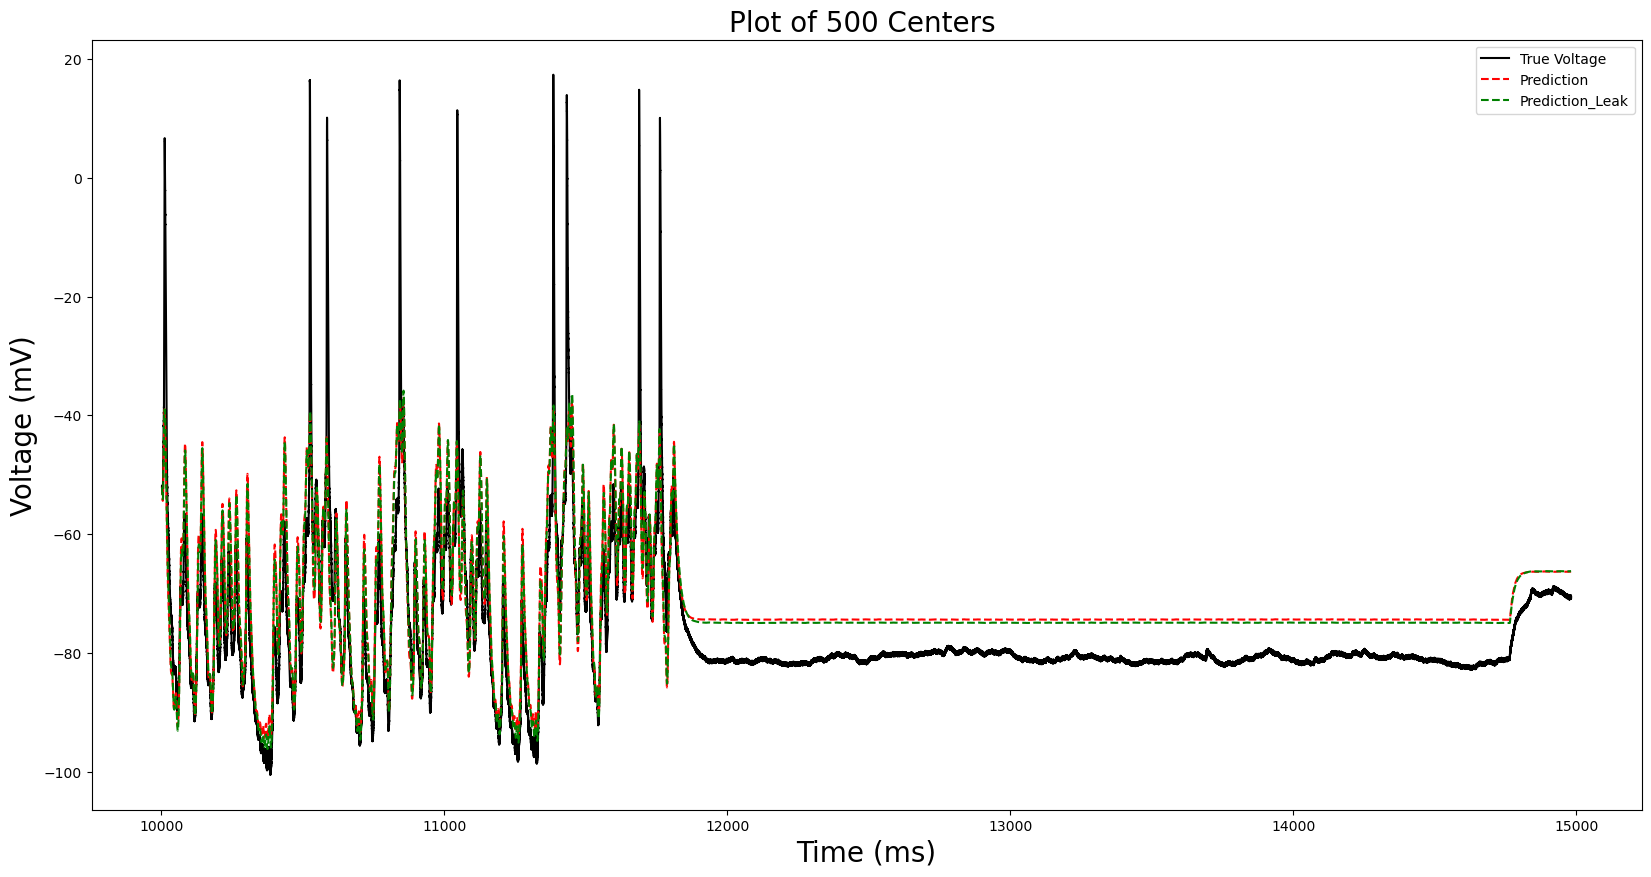

In [98]:
plt.figure(figsize=(20,10))
plt.plot(X,Pdata[bias:bias + PreLength],label = 'True Voltage', color = 'black')
plt.plot(X,PredValidation[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = 'Prediction')
plt.plot(X,PredValidation_Leak[tau*(D-1)+1:tau*(D-1)+PreLength+1],'g--',label = 'Prediction_Leak')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title(f'Plot of {NoCenters_no_thresh} Centers ',fontsize=20)
plt.savefig(dir_fish+f'{NoCenters_no_thresh} Centers.png')

In [99]:
DDF_Leak_ITD.W

array([ 8.88675448e-02,  2.82648872e-01,  6.08535432e-01,  2.04049186e-01,
        2.09842095e-01,  2.57811761e-01,  3.18155875e-01, -6.17233734e-01,
       -1.05785009e+00, -4.33684204e-01,  2.67667510e-01,  4.04295819e-01,
       -2.07996435e-02, -1.93616340e-02,  5.95557644e-01, -1.96512361e-02,
       -1.37121815e+00, -2.83080061e-01,  3.19704725e-01,  6.80221072e-01,
        6.63456049e-01,  2.52516326e-01, -6.70198366e-01, -6.92264011e-01,
        2.28655391e-01, -4.94955906e-01,  3.89930869e-01,  3.15887058e-01,
        5.04133265e-01, -3.49487604e-02, -1.44107691e+00, -4.36381801e-01,
        2.26254012e-01,  4.88921836e-01, -5.68691271e-01,  4.47393338e-01,
        9.84327384e-02,  2.28066587e-01,  6.67854425e-01, -4.50283567e-01,
        3.95706217e-02, -2.36874156e-01,  3.18265122e-03,  2.14517941e-01,
        5.98859031e-01,  5.87878834e-01,  3.18617416e-01,  6.09560748e-01,
       -1.08792329e+00, -1.07209896e+00,  1.58865216e-01,  7.99051915e-02,
       -5.11636646e-01, -

In [100]:
np.sum(DDF_Leak_ITD.W[0:5])

1.3939431303941574

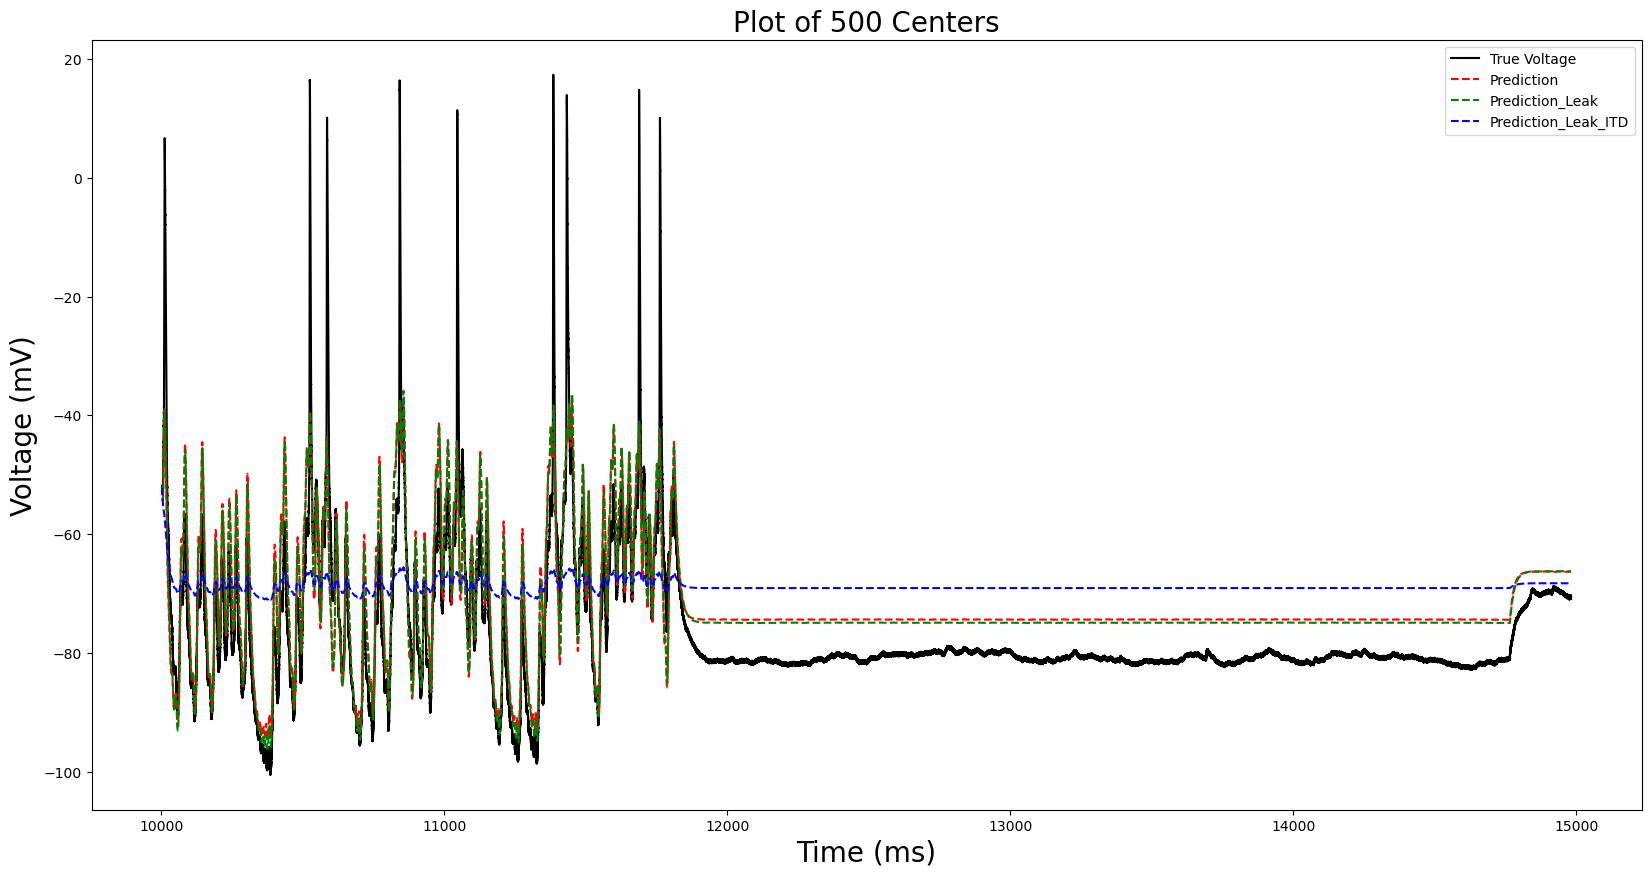

In [101]:
plt.figure(figsize=(20,10))
plt.plot(X,Pdata[bias:bias + PreLength],label = 'True Voltage', color = 'black')
plt.plot(X,PredValidation[tau*(D-1)+1:tau*(D-1)+PreLength+1],'r--',label = 'Prediction')
plt.plot(X,PredValidation_Leak[tau*(D-1)+1:tau*(D-1)+PreLength+1],'g--',label = 'Prediction_Leak')
plt.plot(X,PredValidation_Leak_ITD[tau*(D-1)+1:tau*(D-1)+PreLength+1],'b--',label = 'Prediction_Leak_ITD')
plt.xlabel('Time ('+str(Time_units)+')',fontsize=20)
plt.ylabel('Voltage ('+str(Voltage_units)+')',fontsize=20)
plt.legend()
plt.title(f'Plot of {NoCenters_no_thresh} Centers',fontsize=20)
plt.savefig(dir_fish+f'{NoCenters_no_thresh} Centers (ITD).png')

In [102]:
lines = []
for i in range(len(Center[:, 0])):
    s = str(Center[:, 0][i])+"\t"+str(Center[:, 4][i])+"\t"+str(Center[:, 9][i])+"\t"+str(DDF.W[:-1][i])
    lines.append(s)
with open('figure_18_data.txt', 'w') as f:
    f.write('\n'.join(lines))

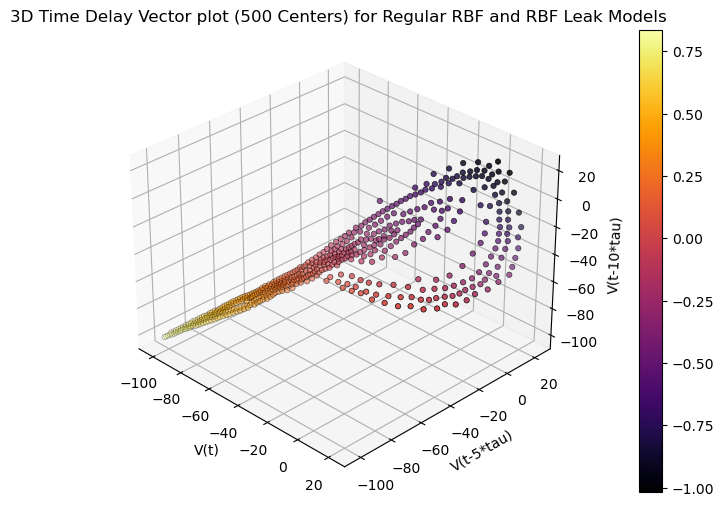

In [103]:
fig=plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
weights = DDF.W[:-1]
p=ax.scatter3D(Center[:, 0], Center[:, 4], Center[:, 9], c=weights, cmap=plt.cm.inferno, s=15, edgecolors='black', linewidths=0.5)
plt.title(f"3D Time Delay Vector plot ({NoCenters_no_thresh} Centers) for Regular RBF and RBF Leak Models")
ax.set_xlabel("V(t)", fontsize=10)
ax.set_ylabel("V(t-5*tau)", fontsize=10)
ax.set_zlabel("V(t-10*tau)", fontsize=10)
ax.view_init(30,-45)
fig.colorbar(p, ax=ax, pad=0.1)  # adjust pad value as needed to move colorbar
plt.savefig(dir_fish+f'Weight plot of {NoCenters_no_thresh} Centers Voltage '+title_here+'.png')

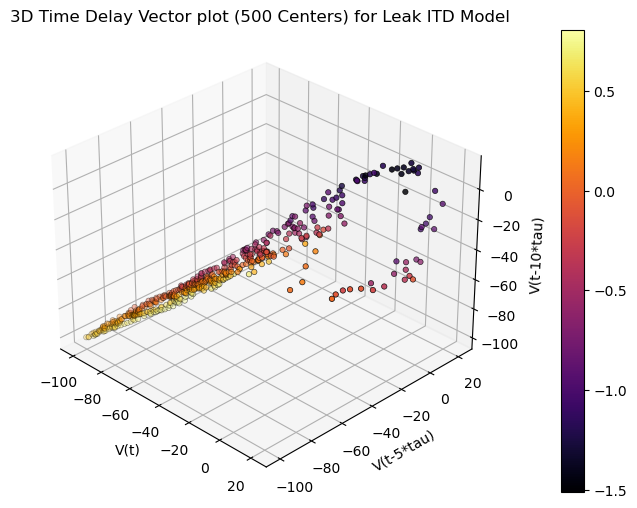

In [104]:
fig=plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
weights = DDF_Leak_ITD.W[:-2]
p=ax.scatter3D(Center_Leak_ITD[:, 0], Center_Leak_ITD[:, 4], Center_Leak_ITD[:, 9], c=weights, cmap=plt.cm.inferno, s=15, edgecolors='black', linewidths=0.5)
plt.title(f"3D Time Delay Vector plot ({NoCenters_no_thresh} Centers) for Leak ITD Model")
ax.set_xlabel("V(t)", fontsize=10)
ax.set_ylabel("V(t-5*tau)", fontsize=10)
ax.set_zlabel("V(t-10*tau)", fontsize=10)
ax.view_init(30,-45)
fig.colorbar(p, ax=ax, pad=0.1)  # adjust pad value as needed to move colorbar
plt.savefig(dir_fish+f'Weight plot of {NoCenters_no_thresh} Centers Leak_ITD Voltage'+title_here+'.png')

In [105]:
DDF_Leak_ITD.W[-2:]

array([3.86744469e-05, 1.66445153e-05])

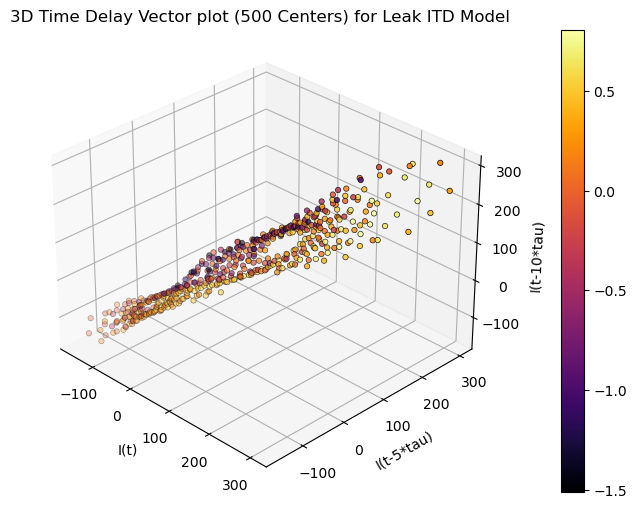

In [106]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
weights = DDF_Leak_ITD.W[:-2]
p = ax.scatter3D(Center_Leak_ITD[:, 10], Center_Leak_ITD[:, 14], Center_Leak_ITD[:, 19], c=weights, cmap=plt.cm.inferno, s=15, edgecolors='black', linewidths=0.5)

plt.title(f"3D Time Delay Vector plot ({NoCenters_no_thresh} Centers) for Leak ITD Model")
ax.set_xlabel("I(t)", fontsize=10)
ax.set_ylabel("I(t-5*tau)", fontsize=10)
ax.set_zlabel("I(t-10*tau)", fontsize=10)
ax.view_init(30,-45)

cbar = fig.colorbar(p, ax=ax, pad=0.1)  # adjust pad value as needed to move colorbar

plt.savefig(dir_fish+f'Weight plot of {NoCenters_no_thresh} Centers Leak_ITD Current'+title_here+'.png')

In [107]:
def SelectRange(low, high, Xdata):
    fish = []
    for x in Voltage_train:
        if x<high and x>low:
            fish.append(x)
    return np.array(fish)
